In [1]:
# Makes it easier to debug
%load_ext autoreload
#%load_ext line_profiler
%autoreload 2

In [3]:
import pylab as plt
import numpy as np
import skimage.transform
import skimage.restoration
from tqdm import tqdm
import skimage.filters
import torch
import torch.nn as nn
import typing as tp
from pyrofit.utils import pad_dims
from torch.nn.functional import grid_sample
from pyro import distributions as dist
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import SersicSource, AnalyticSource
from pyrofit.utils.torchutils import _mid_many, unravel_index
from pyrofit.utils import kNN
from fft_conv_pytorch import fft_conv, FFTConv2d
import swyft
from dataclasses import dataclass
from swyft.alpha.components import (
    RatioEstimatorGaussian1d, MeanStd, SimpleDataset, subsample_posterior,
    get_1d_rect_bounds, append_randomized, valmap, SwyftModel, persist_to_file, 
    equalize_tensors, SwyftTrainer, DictStore, dictstoremap, DictDataset, SwyftModule, SwyftDataModule, RatioSamples
)
import pytorch_lightning as pl
from torch.nn import functional as F

## Todo list

- [ ] Dictionary-valued parameters
- [ ] No enforced network structure

## Basic idea

1) We learn $p(L|I)$ based on joined samples $L, I \sim p(L, I)$ vs marginal samples $L, I \sim p(L) p(I)$.  Here, we identify $z = L$ and $x = I$.
2) We learn $p(S|I, L)$, based on the identification of $x = (I, L)$ and $z=S$.

In [4]:
torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)
DEVICE='cuda'

In [5]:
NPIX = 50
CHANNELS = [0.5, 1, 2, 4, 8, 16, 32]
SIGMA = 0.02
KNN = 3

## Physics model

In [6]:
class RandomSource:
    def __init__(self, npix =  NPIX, channels = CHANNELS, K = 129):
        self._K = K
        self._channels = channels
        self._npix = npix
        
        self._kernels = self._get_kernels(self._K, self._channels)
        self._conv = self._get_kernel_conv(self._kernels)
        
    @staticmethod
    def _get_kernels(K, channels):
        C = len(channels)
        kernel = np.zeros((C, C, K, K))
        x = np.linspace(-64, 64, K)
        X, Y = np.meshgrid(x, x)
        R = (X**2 + Y**2)**0.5

        for i, s in enumerate(channels):
            kern = np.exp(-0.5*R**2/s**2)
            kern /= (kern**2).sum()**0.5
            kernel[i, i] = kern

        return kernel

    @staticmethod
    def _get_kernel_conv(kernel):
        C = len(kernel)
        K = len(kernel[0][0])
        gaussian_weights = nn.Parameter(torch.tensor(kernel).float().cuda())
        conv = FFTConv2d(in_channels = C, out_channels = C, kernel_size=K, bias=False, padding = int(K/2))
        with torch.no_grad():
            conv.weight = gaussian_weights
        return conv

    def _get_source_image(self, seeds, A=0.5, B = 0.3, C = 0.55, D = 4.):
        scales = A*(np.array(self._channels)/max(self._channels))**B
        seeds = seeds * torch.tensor(scales).cuda().float().unsqueeze(1).unsqueeze(2)
        x = torch.linspace(-1, 1, self._npix).to(seeds.device)
        X, Y = torch.meshgrid([x, x])
        R = (X**2 + Y**2)**0.5
        imgc = self._conv(seeds.unsqueeze(0)).squeeze(0).squeeze(0)
        img = imgc.sum(axis=-3)
        img = torch.exp(img)*(1/(1+(R/C)**D))
        return img

    def __call__(self):
        C = len(self._channels)
        return self._get_source_image(torch.randn(C, self._npix, self._npix).cuda()).detach()

In [7]:
class ArraySource(AnalyticSource):
    def __init__(self, image_array, x: float = 0., y: float = 0., scale: float = 1., peak_intensity: float = 1.,
                 origin: tp.Literal['lower', 'upper'] = 'lower', aspect=None, device=None):
        super().__init__(device=device)

        self.x, self.y = x, y
        self.peak_intensity = peak_intensity

        self.image = self._image(image_array, peak_intensity, device)

        if aspect is None:
            aspect = self.image.shape[-2] / self.image.shape[-1]
        self.semi_scale = torch.tensor([scale, (-1 if origin == 'lower' else 1) * aspect * scale], device=device) / 2

    def _image(self, image_array, peak_intensity=None, device=None) -> torch.Tensor:
        image = torch.tensor(image_array)
        if image.shape[-1] in (1, 3, 4):
            image = torch.movedim(image, -1, -3)
        if peak_intensity is not None:
            image = image.to(torch.get_default_dtype())
            image = image / torch.amax(image, (-2, -1), keepdim=True) * peak_intensity
        self.rollback_dims = image.ndim
        return pad_dims(image, ndim=4)[0].to(device=device, dtype=torch.get_default_dtype())

    def flux(self, X, Y):
        grid = torch.stack((X - self.x, Y - self.y), dim=-1).reshape(-1, *X.shape[-2:], 2) / self.semi_scale

        return grid_sample(
            self.image.expand(grid.shape[0], *self.image.shape[-3:]),
            grid,
            align_corners=True
        ).reshape(*X.shape[:-2], *self.image.shape[-self.rollback_dims:-2], *X.shape[-2:])

In [8]:
def get_kNN_idx(X, Y, Xsrc, Ysrc, k = 1):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        P = torch.stack((X, Y), -1).flatten(-3, -2)
        Psrc = torch.stack((Xsrc, Ysrc), -1).flatten(-3, -2)
        idx = unravel_index(kNN(P, Psrc, k).squeeze(-1), Xsrc.shape[-2:])
        idx = torch.reshape(idx, (NPIX, NPIX, k, 2))
        return idx

In [9]:
def deproject_idx(image, kNN_idx):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        k = kNN_idx.shape[-2]
        B = image.shape[0]
        #print(k, B)
        #print(image.shape)
        #print(kNN_idx.shape)
        # TODO: Need to speed up nested python loops
        src_image = torch.stack([torch.stack([image[b, kNN_idx[b, ..., i,0], kNN_idx[b, ..., i,1]] for i in range(k)]) for b in range(B)])
        return src_image

In [10]:
def image_generator(x, y, phi, q, r_ein, slope, src_image):
    res = 0.0125*8                      # resolution in arcsec
    nx, ny = 50, 50                   # number of pixels
    X, Y = get_meshgrid(res, nx, ny)    # grid

    # Lens
    lens = SPLELens(device=DEVICE)
    lens.XY = X,Y
    # Displacement field
    alphas = lens(x=x, y=y, phi=phi, q=q, r_ein=r_ein, slope=slope)

    # Lensing equation
    X_src = X - alphas[..., 0, :, :]
    Y_src = Y - alphas[..., 1, :, :]

    # Source
    source = ArraySource(src_image, peak_intensity = None, scale = 1)

    # Lensed source
    image = source(X=X_src, Y=Y_src)
    
    return image, [X, Y, X_src, Y_src]

## Problem-specific analysis components

In [10]:
def model(pars):
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)    
    x, y, phi, q, r_ein, slope = pars['z_lens']
    slope = 2.0
    src_image = pars['src'].cuda()
    img, coords = image_generator(x, y, phi, q, r_ein, slope, src_image)
    X, Y, Xsrc, Ysrc = coords
    kNN_idx = get_kNN_idx(X/5, -Y/5, Xsrc, Ysrc, k = KNN)  # TODO: Need to sort out strange 1/5 and -1/5 factors
    torch.set_default_tensor_type(torch.FloatTensor)
    return dict(img = img.cpu(), kNN_idx = kNN_idx.cpu(), X = X.cpu(), Y = Y.cpu(), Xsrc = Xsrc.cpu(), Ysrc = Ysrc.cpu())

In [11]:
def noise(d):
    d['img'] = d['img'] + torch.randn_like(d['img'])*SIGMA
    return d

In [12]:
# Draw from source prior
def prior_src(N, bounds = None):
    rnd_src = RandomSource()
    src = torch.stack([rnd_src().cpu() for _ in range(N)])
    return DictStore(src=src)

def prior_lens(N, bounds = None):
    if bounds is not None:
        low = bounds['z_lens'][..., 0]
        high = bounds['z_lens'][..., 1]
    else:
        low =  np.array([-0.2, -0.2, 0, 0.2, 1.0, 1.5])
        high = np.array([0.2, 0.2, 1.5, 0.9, 2.0, 2.5])
    draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
    return DictStore(z_lens = torch.tensor(draw).float())

In [13]:
@persist_to_file
def get_datadict(N, lens_samples = None, bounds = None):
    if lens_samples is None:
        lens_samples = prior_lens(N, bounds = bounds)
    prior_dict = DictStore(**prior_src(N), **lens_samples)
    sim_dict = dictstoremap(model, prior_dict)
    dict_store = DictStore(**prior_dict, **sim_dict)
    return dict_store

In [14]:
@persist_to_file
def get_fake_data():
    dict_store = get_datadict(10)
    dataset = DictDataset(dict_store, hook = noise, x_keys = ['img'], z_keys=['z_lens', 'src'])
    x0, z0 = dataset[0]
    return x0, z0

## Definition of target image

tensor([-0.1346, -0.0670,  0.9889,  0.3908,  1.3470,  2.4581], device='cpu')


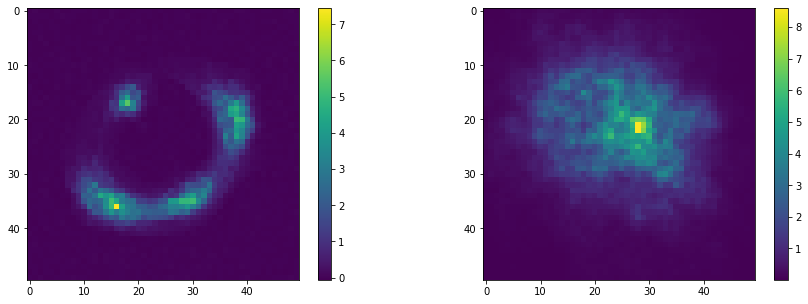

In [15]:
x0, z0 = get_fake_data(file_path = 'fake_data3.pt')

print(z0['z_lens'])
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(x0['img'])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(z0['src'])
plt.colorbar()

In [16]:
class LensNetwork(SwyftModel):
    def __init__(self):
        super().__init__()
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (50, 50)))
        self.CNN = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(20, 40, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(640, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
        )
        self.ptrans = swyft.networks.ParameterTransform(
            6, [(0,), (1,), (2,), (3,), (4,), (5,)], online_z_score=False
        )
        n_marginals, n_block_parameters = self.ptrans.marginal_block_shape
        n_observation_features = 16
        self.classifier = swyft.networks.MarginalClassifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=256,
            dropout_probability = 0.1,
            num_blocks=3,
        )
        
    def forward(self, x, z):
        # Digesting x
        x = dict(img = x['img'])
        x = self.online_z_score(x)['img']
        x = self.CNN(x.unsqueeze(1)).squeeze(1)
        
        # Digesting z
        z = self.ptrans(z['z_lens'])
        
        # Combine!
        x, z = equalize_tensors(x, z)
        ratios = self.classifier(x, z)
        ratios = ratios.unsqueeze(-1)
        ratios = torch.cat([ratios, z], dim=-1)
        return dict(z_lens=ratios)

In [17]:
class SourceNetwork(SwyftModel):
    def __init__(self):
        super().__init__()
        self.l = torch.nn.Linear(10, 10)
        self.reg1d = RatioEstimatorGaussian1d(momentum = 0.1)
        self.L = torch.nn.Linear(2500, 2500)
        
    def get_img_rec(self, x):
        x_img = x['img']
        x_kNN_idx = x['kNN_idx']
        x_img_rec = deproject_idx(x_img, x_kNN_idx)[:,:,:,:].mean(dim=1)
        x_img_rec = self.L(x_img_rec.view(-1, NPIX*NPIX)).view(-1, NPIX, NPIX)*0 + x_img_rec
        return x_img_rec
    
    def forward(self, x, z):
        x_img_rec = self.get_img_rec(x)
        z_src = z['src']
        x_img_rec, z_src = equalize_tensors(x_img_rec, z_src)
        ratios = self.reg1d(x_img_rec, z_src)
        return dict(z_src = ratios)

# Workflow

In [18]:
SMOKE_TEST = True

In [19]:
Ntrain1, R1, ME = 2000, 3, 10
tag = 'v4'

In [ ]:
bounds = None
results = []
for i in range(R1):
    # s1: img, lens, src ~ p(img|lens, src)p(lens)p(src)
    s1 = get_datadict(Ntrain1, bounds = bounds, file_path = 'data_%s_%i_i%i.pt'%(tag, Ntrain1, i))
    
    # r1: p(z_lens|img)/p(z_lens)
    r1 = LensNetwork()
    
    # d1: split img vs z_lens
    d1 = DictDataset(s1, hook = noise, x_keys = ['img'], z_keys=['z_lens'])
    l1 = torch.utils.data.DataLoader(d1, batch_size=64)  # TODO: Absorb fitter
    
    # Train r1 with d1, based on s1
    t1 = SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = ME)
    t1.fit(r1, l1, l1)

    # r2: p(src|z_lens, img)/p(src)
    r2 = SourceNetwork()
    
    # d2: split (img, kNN_idx) vs src
    d2 = DictDataset(s1, hook = noise, x_keys = ['img', 'kNN_idx'], z_keys=['src'])
    l2 = torch.utils.data.DataLoader(d2, batch_size=64)  # TODO: Absorb in fitter
    
    # Train r2 with d1, based on s1
    t2 = SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 3)
    t2.fit(r2, l2, l2)
    
    # ws1: z_lens ~ p(z_lens|img_obs)  --  these are weighted samples
    ws1 = t1.infer(l1, condition_x = x0)   # TODO: Return some weighted sample class
    
    # d2: lens ~ p(z_lens|img_obs)  --  unweighted samples
    s2 = dict(z_lens = subsample_posterior(100, ws1['z_lens']))  # TODO: Should be just sample statement
    
    # d3: img, lens, src ~ p(img|lens, src)p(lens|img_obs)
    s3 = get_datadict(100, lens_samples = s2)
    
    # d3: split (img, kNN) vs (z_lens, src)
    d3 = DictDataset(s3, hook = noise, x_keys = ['img', 'kNN_idx'], z_keys=['z_lens', 'src'])
    l3  = torch.utils.data.DataLoader(d3, batch_size=16)  # TODO: Absorb
    
    # ws2: src ~ p(src|img_obs) = \int dlens p(src|lens, img_obs)*p(lens|img_obs)  --  weighted samples
    ws2 = t2.infer(l3, condition_x = x0)  # TODO: Return weighted sample class
    
    # Rectangle Bounds
    all_inference = dict(**ws1, **ws2)
    bounds = get_1d_rect_bounds(all_inference, th = 1e-5)  # for p(z_lens)
    results.append(dict(bounds = bounds, t1=t1, t2=t2, d1=d1, ws1=ws1, ws2=ws2))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                         | Params
----------------------------------------------------------------
0 | online_z_score | OnlineDictStandardizingLayer | 0     
1 | CNN            | Sequential                   | 93.3 K
2 | ptrans         | ParameterTransform           | 0     
3 | classifier     | MarginalClassifier           | 2.4 M 
----------------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.038    Total estimated model params size (MB)
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/weniger/codes/swyft_papergui/notebooks/GUI paper/lightning_logs/version_8757722/checkpoints exists and is not empty.
  rank_zero_warn(f"Ch

Validation sanity check: 0it [00:00, ?it/s]

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/_reduction.py:42: UserWarning: size_avera

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params
---------------------------------------------------
0 | l     | Linear                   | 110   
1 | reg1d | RatioEstimatorGaussian1d | 0     
2 | L     | Linear                   | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.010    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1398: UserWarning: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `predict(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/weniger/codes/swyft_papergui/notebooks/GUI paper/lightning_logs/version_8757722/checkpoints/epoch=2-step=95-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/weniger/codes/swyft_papergui/notebooks/GUI paper/lightning_logs/version_8757722/checkpoints/epoch=2-step=95-v6.ckpt
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a b

Predicting: 32it [00:00, ?it/s]



  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-6-6c7c12c26adf>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


  4%|▍         | 4/100 [00:00<00:02, 35.16it/s]

  8%|▊         | 8/100 [00:00<00:02, 3

Predicting: 32it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                         | Params
----------------------------------------------------------------
0 | online_z_score | OnlineDictStandardizingLayer | 0     
1 | CNN            | Sequential                   | 93.3 K
2 | ptrans         | ParameterTransform           | 0     
3 | classifier     | MarginalClassifier           | 2.4 M 
----------------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.038    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params
---------------------------------------------------
0 | l     | Linear                   | 110   
1 | reg1d | RatioEstimatorGaussian1d | 0     
2 | L     | Linear                   | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.010    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/weniger/codes/swyft_papergui/notebooks/GUI paper/lightning_logs/version_8757722/checkpoints/epoch=9-step=319-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/weniger/codes/swyft_papergui/notebooks/GUI paper/lightning_logs/version_8757722/checkpoints/epoch=9-step=319-v6.ckpt


Predicting: 32it [00:00, ?it/s]



  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▍         | 4/100 [00:00<00:02, 37.51it/s]

  8%|▊         | 8/100 [00:00<00:02, 37.84it/s]

 12%|█▏        | 12/100 [00:00<00:02, 37.99it/s]

 16%|█▌        | 16/100 [00:00<00:02, 38.04it/s]

 20%|██        | 20/100 [00:00<00:02, 37.51it/s]

 24%|██▍       | 24/100 [00:00<00:02, 37.46it/s]

 28%|██▊       | 28/100 [00:00<00:01, 37.68it/s]

 32%|███▏      | 32/100 [00:00<00:01, 37.81it/s]

 36%|███▌      | 36/100 [00:00<00:01, 37.67it/s]

 40%|████      | 40/100 [00:01<00:01, 37.34it/s]

 44%|████▍     | 44/100 [00:01<00:01, 37.08it/s]

 48%|████▊     | 48/100 [00:01<00:01, 37.03it/s]

 52%|█████▏    | 52/100 [00:01<00:01, 37.25it/s]

 56%|█████▌    | 56/100 [00:01<00:01, 37.38it/s]

 60%|██████    | 60/100 [00:01<00:01, 37.43it/s]

 64%|██████▍   | 64/100 [00:01<00:00, 37.31it/s]

 68%|██████▊   | 68/100 [00:01<00:00, 37.21it/s]

 72%|███████▏  | 72/100 [00:01<00:00, 37.20it/s]

 76%|███████▌  | 76/100 [00:02<00:00, 36.90it/s]

 80%|████

Predicting: 32it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                         | Params
----------------------------------------------------------------
0 | online_z_score | OnlineDictStandardizingLayer | 0     
1 | CNN            | Sequential                   | 93.3 K
2 | ptrans         | ParameterTransform           | 0     
3 | classifier     | MarginalClassifier           | 2.4 M 
----------------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.038    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params
---------------------------------------------------
0 | l     | Linear                   | 110   
1 | reg1d | RatioEstimatorGaussian1d | 0     
2 | L     | Linear                   | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.010    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/weniger/codes/swyft_papergui/notebooks/GUI paper/lightning_logs/version_8757722/checkpoints/epoch=9-step=319-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/weniger/codes/swyft_papergui/notebooks/GUI paper/lightning_logs/version_8757722/checkpoints/epoch=9-step=319-v7.ckpt


Predicting: 32it [00:00, ?it/s]



  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▍         | 4/100 [00:00<00:02, 38.19it/s]

  8%|▊         | 8/100 [00:00<00:02, 38.25it/s]

 12%|█▏        | 12/100 [00:00<00:02, 38.24it/s]

 16%|█▌        | 16/100 [00:00<00:02, 38.23it/s]

 20%|██        | 20/100 [00:00<00:02, 38.22it/s]

 24%|██▍       | 24/100 [00:00<00:01, 38.11it/s]

 28%|██▊       | 28/100 [00:00<00:01, 38.15it/s]

 32%|███▏      | 32/100 [00:00<00:01, 38.19it/s]

 36%|███▌      | 36/100 [00:00<00:01, 38.24it/s]

 40%|████      | 40/100 [00:01<00:01, 38.25it/s]

 44%|████▍     | 44/100 [00:01<00:01, 36.53it/s]

 48%|████▊     | 48/100 [00:01<00:01, 36.98it/s]

 52%|█████▏    | 52/100 [00:01<00:01, 35.89it/s]

 56%|█████▌    | 56/100 [00:01<00:01, 36.22it/s]

 60%|██████    | 60/100 [00:01<00:01, 36.51it/s]

 64%|██████▍   | 64/100 [00:01<00:00, 36.72it/s]

 68%|██████▊   | 68/100 [00:01<00:00, 36.84it/s]

 72%|███████▏  | 72/100 [00:01<00:00, 36.95it/s]

 76%|███████▌  | 76/100 [00:02<00:00, 37.01it/s]

 80%|████

Predicting: 32it [00:00, ?it/s]

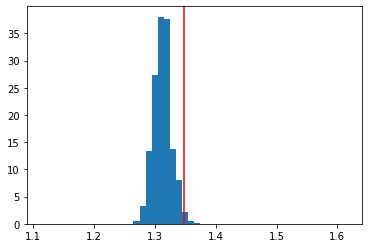

In [53]:
i = 4
#print(1)
#inference = trainer.infer(train_loader, condition_x = x0)
inference = results[-1]['ws1']
z = inference['z_lens']
w = z[:,i,0].detach().cpu().numpy()
p = z[:,i,1].detach().cpu().numpy()
plt.axvline(z0['z_lens'][i].cpu(), color='r')
wn = np.exp(w-w.max())
plt.hist(p, weights = wn, bins = 50);

In [60]:
ws2['z_src'].mean(axis=0).shape

torch.Size([50, 50, 2])

In [78]:
b = bounds['z_src']

In [92]:
m = b.mean(axis=-1)

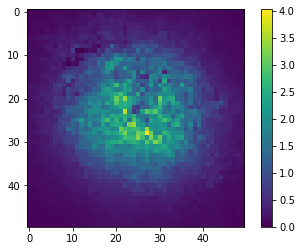

In [87]:
s = b.std(axis=-1)
plt.imshow(s)
plt.colorbar()

In [88]:
src = rnd_src().cpu()

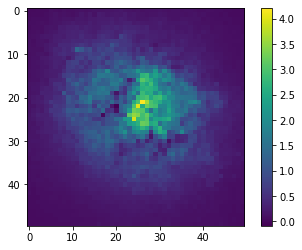

In [148]:
rnd_src = RandomSource()
dist = rnd_src().cpu() - rnd_src().cpu()
dist /= dist.std()
src = dist*s*0.2 + m
plt.imshow(src)
plt.colorbar()